# Convex-relaxed Neural Network Robustness Verification Demo
This notebook demonstrates the different robustness verification methods (MILP, LP-ALL, LP-LAST, and LP-GREEDY), used in our paper [A Convex Relaxation Barrier to Tight Robustness Verfication of Neural Networks](https://arxiv.org/abs/1902.08722), on a toy example. LP-Greedy is the dual network method of [Wong and Kolter](https://github.com/locuslab/convex_adversarial).

In all the below experiments, we find the margins of each network given a data point and a maximum allowed perturbation. Here, the margins are defined as the difference between the logits corresponding to the predicted label and every other label, respectively. The network is certified to be robust around data point X if all the margins are positive.

Background Concepts

Logits: The raw output values of the last layer of a neural network before applying the softmax function. These can be thought of as confidence scores for each class.
Margin: The difference between the logit of the correct (or predicted) label and the logits of all other labels. A positive margin indicates that the network's confidence in the correct label is higher than its confidence in any incorrect label.
Scenario
Imagine you have a simple neural network that classifies images into three categories: Cats (0), Dogs (1), and Birds (2). For a given image of a dog, the network outputs the following logits: [2.0,5.0,1.0]  This means the network is most confident that the image is of a Dog (label 1), moderately confident it's a Cat (label 0), and least confident it's a Bird (label 2).

Perturbation and Robustness
Let's say we allow a maximum perturbation (ϵ) to the input image that slightly alters its pixels, aiming to test the network's robustness. An adversarial attack tries to minimize the margin between the correct class's logit and the highest other logit to change the network's prediction.

Computing Margins
Given the correct label is Dog (1) with a logit of 5.0, we calculate the margins with respect to the other classes:

Margin with respect to Cats (0): 5.0−2.0=3.0

Margin with respect to Birds (2): 5.0− 1.0=4.0


Interpretation
Both margins are positive, indicating that even with the maximum allowed perturbation (ϵ), the logits for the correct class (Dog) remain higher than for any other class. This means no small alteration within the defined range can trick the network into changing its prediction from Dog to either Cat or Bird.

Certification of Robustness
Since all margins calculated from the logits are positive, we certify the network as robust around the data point 
X under the allowed perturbation. In other words, the network's prediction for this particular image of a Dog is secure against any adversarial example crafted within the bounds of ϵ.

In [2]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

from wong_kolter.version0point2 import Affine, full_bias
from wong_kolter import DualNetBounds as DualNetBounds

#import gurobipy
import cvxpy as cp

#### Setup


In [3]:
## The maximum allowed l_infinity perturbation of the input.
epsilon = 0.01
############################################

torch.manual_seed(1)

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

# Load dataset
mnist_test = datasets.MNIST('data', train=False, download=True, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=1, shuffle=False, pin_memory=True)
for X,y in test_loader:
    break

sample = X.flatten().numpy() # The sample that we want to verify the network around

### A toy randomly initialized neural network
input_dim = sample.shape[0]
num_classes = 10

net = nn.Sequential(
    Flatten(),
    nn.Linear(input_dim,4),
    nn.ReLU(),
    nn.Linear(4,4),
    nn.ReLU(),
    nn.Linear(4,num_classes)
)

logits = net(X)
y_pred = logits.max(1)[1]
print('The predicted class is "{}". We want to check if within a maximum l_infinity perturbation of {}, this predicted label changes. \
If this is the case, the network is NOT robust around this data point. Otherwise, the network is robust.'.format(y_pred.item(), epsilon))

The predicted class is "7". We want to check if within a maximum l_infinity perturbation of 0.01, this predicted label changes. If this is the case, the network is NOT robust around this data point. Otherwise, the network is robust.


In [64]:
import torch
from torch import nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms

# The maximum allowed l_infinity perturbation of the input.
epsilon = 0.1
############################################

torch.manual_seed(1)

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

# Load dataset
mnist_test = datasets.MNIST('data', train=False, download=True, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=1, shuffle=False, pin_memory=True)

### A toy randomly initialized neural network
input_dim = 28 * 28  # MNIST images are 28x28
num_classes = 10

net = nn.Sequential(
    Flatten(),
    nn.Linear(input_dim, 4),
    nn.ReLU(),
    nn.Linear(4, 4),
    nn.ReLU(),
    nn.Linear(4, num_classes)
)

# We want to check the robustness for 100 examples
robustness_checks = []
for i, (X, y) in enumerate(test_loader):
    if i >= 1000:  # Only check the first 100 examples
        break
    logits = net(X)
    y_pred = logits.max(1)[1]
    robust = 'robust' if y_pred.item() == y.item() else 'not robust'
    robustness_checks.append((i, y.item(), y_pred.item(), robust))
    print('Example {}: True label "{}", Predicted label "{}", Status: {}'.format(i, y.item(), y_pred.item(), robust))

# Now you have the robustness status for the first 100 examples in robustness_checks


Example 0: True label "7", Predicted label "9", Status: not robust
Example 1: True label "2", Predicted label "9", Status: not robust
Example 2: True label "1", Predicted label "9", Status: not robust
Example 3: True label "0", Predicted label "9", Status: not robust
Example 4: True label "4", Predicted label "9", Status: not robust
Example 5: True label "1", Predicted label "9", Status: not robust
Example 6: True label "4", Predicted label "9", Status: not robust
Example 7: True label "9", Predicted label "9", Status: robust
Example 8: True label "5", Predicted label "9", Status: not robust
Example 9: True label "9", Predicted label "9", Status: robust
Example 10: True label "0", Predicted label "9", Status: not robust
Example 11: True label "6", Predicted label "9", Status: not robust
Example 12: True label "9", Predicted label "9", Status: robust
Example 13: True label "0", Predicted label "9", Status: not robust
Example 14: True label "1", Predicted label "9", Status: not robust
Ex

In [4]:
# Import necessary libraries
import torch
from torch import nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import os
import numpy as np

# # Define the model architecture
# class SimpleCNN(nn.Module):
#     def __init__(self):
#         super(SimpleCNN, self).__init__()
#         self.stack = nn.Sequential(
#             nn.Conv2d(1, 16, kernel_size=4, stride=2, padding=1),
#             nn.ReLU(),
#             nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1),
#             nn.ReLU(),
#             nn.Flatten(),
#             nn.Linear(32*7*7, 100),
#             nn.ReLU(),
#             nn.Linear(100, 10),
#         )

#     def forward(self, x):
#         x = self.stack(x)
#         return x

# Set manual seed
torch.manual_seed(1)

# Initialize the model
# net = SimpleCNN()
net = nn.Sequential(
    nn.Conv2d(1, 16, 4, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 32, 4, stride=2, padding=1),
    nn.ReLU(),
    Flatten(),
    nn.Linear(32*7*7,100),
    nn.ReLU(),
    nn.Linear(100, 10)
)

# Load datasets with transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Training dataset
mnist_train = datasets.MNIST(root='data', train=True, download=True, transform=transform)
train_loader = DataLoader(mnist_train, batch_size=64, shuffle=True)

# Test dataset
mnist_test = datasets.MNIST(root='data', train=False, download=True, transform=transform)
test_loader = DataLoader(mnist_test, batch_size=1, shuffle=False)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    for images, labels in train_loader:
        # Forward pass
        outputs = net(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Now, let's proceed with the testing and saving of correct examples as described before.
net.eval()  # Set the model to evaluation mode
correct_examples = []
correct_counts = {str(i): 0 for i in range(10)}

with torch.no_grad():
    for images, labels in test_loader:
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        if predicted == labels:
            correct_counts[str(labels.item())] += 1
            correct_examples.append((images, labels))

# Save the correct examples
if not os.path.exists('correct_examples'):
    os.makedirs('correct_examples')

for idx, (image, label) in enumerate(correct_examples):
    np.save(f'correct_examples/image_{idx}_label_{label.item()}.npy', image.numpy())

# Print out the count of correct examples for each class
for label, count in correct_counts.items():
    print(f'Class {label}: {count} correct examples')


Epoch [1/5], Loss: 0.0519
Epoch [2/5], Loss: 0.0630
Epoch [3/5], Loss: 0.2648
Epoch [4/5], Loss: 0.0006
Epoch [5/5], Loss: 0.0329
Class 0: 971 correct examples
Class 1: 1129 correct examples
Class 2: 1019 correct examples
Class 3: 1001 correct examples
Class 4: 972 correct examples
Class 5: 882 correct examples
Class 6: 945 correct examples
Class 7: 1012 correct examples
Class 8: 954 correct examples
Class 9: 979 correct examples


In [249]:
output = net(images)
print("Network output shape:", output.shape)


Network output shape: torch.Size([1, 10])


In [250]:
image.shape

torch.Size([1, 1, 28, 28])

## LP-GREEDY (Correct Examples trained on simple CNN)
This is the dual LP formulation of [Wong and Kolter 2018](https://arxiv.org/abs/1711.00851). 

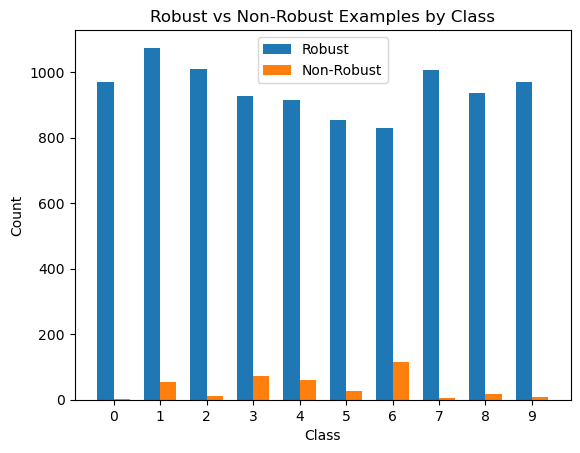

Class 0: Robust: 970, Non-Robust: 1
Class 1: Robust: 1074, Non-Robust: 55
Class 2: Robust: 1009, Non-Robust: 10
Class 3: Robust: 928, Non-Robust: 73
Class 4: Robust: 913, Non-Robust: 59
Class 5: Robust: 854, Non-Robust: 28
Class 6: Robust: 829, Non-Robust: 116
Class 7: Robust: 1007, Non-Robust: 5
Class 8: Robust: 936, Non-Robust: 18
Class 9: Robust: 970, Non-Robust: 9


In [256]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Assuming the setup is as described and correct_examples contains your data
num_classes = 10  # Adjust based on your dataset
epsilon = 0.25  # Example epsilon, adjust as necessary

# Initialize counts for robust and non-robust examples per class
robust_counts = {str(i): 0 for i in range(num_classes)}
non_robust_counts = {str(i): 0 for i in range(num_classes)}

for image, label in correct_examples:
    image = image.squeeze(0)  # Remove batch dimension if present
    label = label.item()  # Get the scalar value

    # Initialize DualNetBounds with the correct parameters (modify as needed for your implementation)
    dual_net = DualNetBounds(net, image.unsqueeze(0), epsilon, bounded_input=True)  # Ensure image has a batch dimension

    # Construct the C matrix
    C = torch.eye(num_classes).type_as(image)[label].unsqueeze(1) - torch.eye(num_classes).type_as(image).unsqueeze(0)
    
    # Compute margins using LP-GREEDY
    margins_lp_greedy = dual_net(C).data.flatten().numpy()

    # Check robustness
    is_robust = np.all(margins_lp_greedy >= 0)
    if is_robust:
        robust_counts[str(label)] += 1
    else:
        non_robust_counts[str(label)] += 1

# Visualization
labels = np.arange(num_classes)
robust_nums = [robust_counts[str(i)] for i in labels]
non_robust_nums = [non_robust_counts[str(i)] for i in labels]

fig, ax = plt.subplots()
bar_width = 0.35
index = np.arange(num_classes)

bar1 = ax.bar(index, robust_nums, bar_width, label='Robust')
bar2 = ax.bar(index + bar_width, non_robust_nums, bar_width, label='Non-Robust')

ax.set_xlabel('Class')
ax.set_ylabel('Count')
ax.set_title('Robust vs Non-Robust Examples by Class')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(labels)
ax.legend()

plt.show()

# Print counts
for i in labels:
    print(f'Class {i}: Robust: {robust_counts[str(i)]}, Non-Robust: {non_robust_counts[str(i)]}')


# MILP (verify correct examples test on MNIST dataset)
This is a simple implementation of the MILP formulation for ReLU networks of the [Tjeng et. al., 2019](https://arxiv.org/abs/1711.07356). MILP solves the verification problem exactly, there fore is tighter than the above algorithms.

In [ ]:
def get_linearLayers_net(W, b):
    layers_list = [[nn.Linear(ww.shape[1],ww.shape[0]), nn.ReLU()] for ww in W]
    flat_layers_list = [item for sublist in layers_list for item in sublist]
    net = nn.Sequential(Flatten(),
                       *flat_layers_list[:-1]
                       )
    # Load weights
    i = 0
    for idx,l in enumerate(net):
        if isinstance(l, nn.Linear):
            l.weight.data = torch.Tensor(W[i])
            l.bias.data = torch.Tensor(b[i])
            i += 1
    return net


def init_affine(net, X):
    layers = [l for l in net if isinstance(l, (nn.Linear, nn.Conv2d))]
    affine = [Affine(l) for l in layers]

    _ = X.view(1,-1)
    for a in affine: 
        _ = a(_)

    biases = [full_bias(l, affine[i].out_features) 
                    for i,l in enumerate(layers)]
    return affine, biases

In [268]:
import numpy as np

import torch
from torch.autograd import Variable
import cvxpy as cp
import matplotlib.pyplot as plt

# Assuming `correct_examples` and `num_classes` are already defined
epsilon = 0.1  # Perturbation limit

robust_counts = np.zeros(num_classes)
non_robust_counts = np.zeros(num_classes)

for image, label in correct_examples:
    X = image.unsqueeze(0)  # Ensure X has the correct shape
    y_pred = label  # Assuming label is correctly predicted

    # Initialize matrices and variables for MILP
    C = np.eye(num_classes)[y_pred] - np.eye(num_classes)
    affine, biases = init_affine(net, X)  # Assuming this function is defined elsewhere
    num_linear_layers = len(affine)

    W = [l(Variable(torch.eye(l.in_features))).t().cpu().data.numpy() for l in affine]
    b = [bias.view(-1).cpu().data.numpy() for bias in biases]

    # # Placeholder initialization of zu and zl with generic bounds for demonstration purposes
    # # In practice, these should be computed based on the network and the data
    # zu = [np.ones(shape=(l.out_features,)) * 1.0 for l in affine]  # Example upper bounds
    # zl = [np.zeros(shape=(l.out_features,)) for l in affine]  # Example lower bounds

    z = [cp.Variable(l.in_features) for l in affine[:num_linear_layers]]
    zhat = [cp.Variable(l.out_features) for l in affine[:num_linear_layers]]
    a = [cp.Variable(l.out_features, boolean=True) for l in affine[:num_linear_layers]]

    # Define MILP constraints
    cons_eq = [zhat[i] == W[i] @ z[i] + b[i] for i in range(num_linear_layers)]
    cons_ball = [z[0] >= X.cpu().numpy().flatten() - epsilon, z[0] <= X.cpu().numpy().flatten() + epsilon, z[0] >= 0, z[0] <= 1.0]
    cons_zero = [z[i] >= 0 for i in range(1, num_linear_layers)]
    cons_linear = [z[i+1] >= zhat[i] for i in range(num_linear_layers-1)]
    cons_milp_1 = [z[i+1] <= cp.multiply(zu[i], a[i]) for i in range(num_linear_layers-1)]
    cons_milp_2 = [z[i+1] <= zhat[i] - cp.multiply(zl[i], (1 - a[i])) for i in range(num_linear_layers-1)]

    cons = cons_eq + cons_ball + cons_zero + cons_linear + cons_milp_1 + cons_milp_2

    margins_milp = []
    for node_idx in range(affine[num_linear_layers-1].out_features):
        if node_idx == y_pred:
            margins_milp.append(0)
            continue
        f_primal_1 = cp.Problem(cp.Minimize(C[node_idx] @ zhat[-1]), cons).solve(verbose=False, solver=cp.ECOS_BB)
        margins_milp.append(f_primal_1)

    # Assess robustness based on margins
    if all(margin >= 0 for margin in margins_milp):
        robust_counts[label] += 1
    else:
        non_robust_counts[label] += 1

# Plotting robust vs non-robust counts for each class
labels = np.arange(num_classes)
bar_width = 0.35

fig, ax = plt.subplots()
bar1 = ax.bar(labels - bar_width/2, robust_counts, bar_width, label='Robust')
bar2 = ax.bar(labels + bar_width/2, non_robust_counts, bar_width, label='Non-Robust')

ax.set_xlabel('Class')
ax.set_ylabel('Count')
ax.set_title('Robust vs Non-Robust Examples by Class')
ax.set_xticks(labels)
ax.set_xticklabels(labels)
ax.legend()

plt.show()


# LP-ALL (Correct Examples)
This is the layer-wise optimal convex relaxation formulation that is defined in Section 5.1 of [our paper](https://arxiv.org/abs/1902.08722). LP-ALL is tighter than both LP-LAST and LP-GREEDY.

In [ ]:
import numpy as np
import cvxpy as cp
import torch
from torch.autograd import Variable
import matplotlib.pyplot as plt



num_classes = 10  # MNIST dataset has 10 classes
epsilon = 0.25  # Perturbation range

robust_counts = np.zeros(num_classes)
non_robust_counts = np.zeros(num_classes)

for image, label in correct_examples:
    X = image.unsqueeze(0)  # Ensure X has the correct shape
    y_pred = label  # Assuming label is correctly predicted

    C = np.eye(num_classes)[y_pred] - np.eye(num_classes)

    affine, biases = init_affine(net, X)
    num_linear_layers = len(affine)

    # Get the weights and biases from the network. Will be used in the LP formulation later. 
    W = [l(Variable(torch.eye(l.in_features))).t().cpu().data.numpy() for l in affine]
    b = [bias.view(-1).cpu().data.numpy() for bias in biases]

    zl = [[] for i in range(num_linear_layers)]
    zu = [[] for i in range(num_linear_layers)]

    for k in range(num_linear_layers):
        print('Layer: ',k)
        print('Number of nodes in layer {0} is {1}'.format(k, affine[k].out_features))
        z = [cp.Variable(l.in_features) for l in affine[:k+1]]
        zhat = [cp.Variable(l.out_features) for l in affine[:k+1]]

        # Constraints of the LP
        cons_eq = [zhat[i] == W[i]*z[i] + b[i] for i in range(k+1)]
        cons_ball = [z[0] >= sample - epsilon, z[0] <= sample + epsilon, z[0] >= 0, z[0] <= 1.0]
        cons_zero = [z[i] >= 0 for i in range(1,k+1)]
        cons_linear = [z[i+1] >= zhat[i] for i in range(k)]
        cons_upper = [(cp.multiply(-(np.maximum(zu[i],0) - np.maximum(zl[i], 0)), zhat[i]) +
                        cp.multiply((zu[i] - zl[i]), z[i+1]) <= 
                        zu[i]*np.maximum(zl[i],0) - zl[i]*np.maximum(zu[i],0)) for i in range(k)]
        cons = cons_eq + cons_ball + cons_zero + cons_linear + cons_upper

        margins_lp_all = []
        for node_idx in range(affine[k].out_features):
            if k == num_linear_layers-1:
                if node_idx == y_pred.item():
                    margins_lp_all.append(0)
                    continue
                f_primal_1 = cp.Problem(cp.Minimize(C[node_idx]*zhat[-1]), cons).solve(verbose=False, solver=cp.ECOS)
                margins_lp_all.append(f_primal_1)
            else:
                f_primal_1 = cp.Problem(cp.Minimize(zhat[-1][node_idx]), cons).solve(verbose=False, solver=cp.ECOS)
                f_min = zhat[-1][node_idx].value
                zl[k].append(f_min)

                f_primal_2 = cp.Problem(cp.Maximize(zhat[-1][node_idx]), cons).solve(verbose=False, solver=cp.ECOS)
                f_max = zhat[-1][node_idx].value
                zu[k].append(f_max)
        zl[k] = np.array(zl[k])
        zu[k] = np.array(zu[k])
        
        is_robust_example = all(margin >= 0 for margin in margins_lp_all)  # Adapt based on your margins calculation
        if is_robust_example:
            robust_counts[y_pred] += 1
        else:
            non_robust_counts[y_pred] += 1

# Visualization and summary
labels = np.arange(num_classes)
fig, ax = plt.subplots()
bar_width = 0.35
index = np.arange(num_classes)

bar1 = ax.bar(index, robust_counts, bar_width, label='Robust')
bar2 = ax.bar(index + bar_width, non_robust_counts, bar_width, label='Non-Robust')

ax.set_xlabel('Class')
ax.set_ylabel('Count')
ax.set_title('Robust vs Non-Robust Examples by Class')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(labels)
ax.legend()

plt.show()


Class 7: 1028 samples
Class 2: 1032 samples
Class 1: 1135 samples
Class 0: 980 samples
Class 4: 982 samples
Class 9: 1009 samples
Class 5: 892 samples
Class 6: 958 samples
Class 3: 1010 samples
Class 8: 974 samples


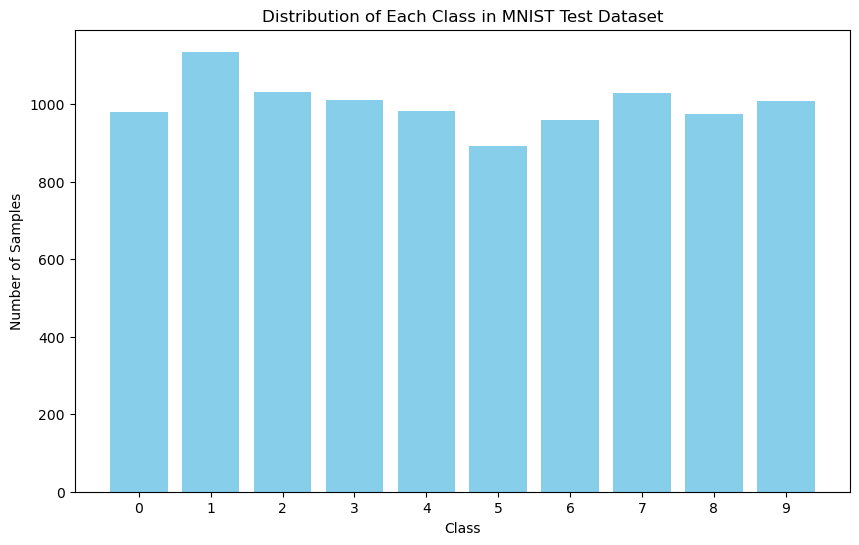

In [193]:
from collections import Counter
import torchvision.datasets as datasets
import torch.utils.data

# Load MNIST test dataset
mnist_test = datasets.MNIST('data', train=False, download=True, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=1, shuffle=False, pin_memory=True)

# Initialize a Counter to tally occurrences of each label
label_counts = Counter()

# Iterate through the test dataset
for _, label in test_loader:
    label_counts[label.item()] += 1

# Print the distribution of each class
for label, count in label_counts.items():
    print(f'Class {label}: {count} samples')

# Optionally, visualize the distribution
import matplotlib.pyplot as plt

labels, counts = zip(*label_counts.items())  # Unzip keys and values

plt.figure(figsize=(10, 6))
plt.bar(labels, counts, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Distribution of Each Class in MNIST Test Dataset')
plt.xticks(labels)
plt.show()


## LP-GREEDY
This is the dual LP formulation of [Wong and Kolter 2018](https://arxiv.org/abs/1711.00851). 

Robustness certified for epsilon=0.01 using LP-GREEDY


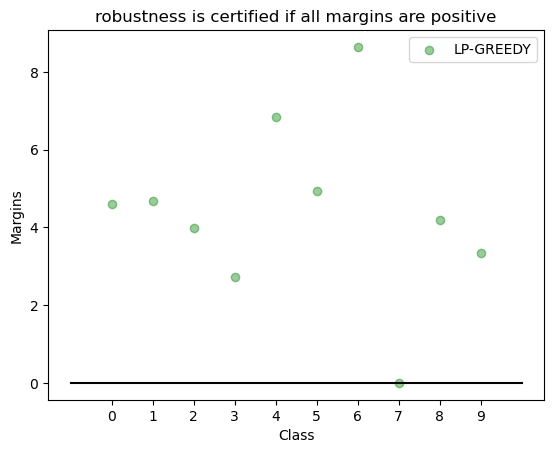

In [5]:
dual_net = DualNetBounds(net, X, epsilon, bounded_input=True)
C = torch.eye(num_classes).type_as(X)[y_pred].unsqueeze(1) - torch.eye(num_classes).type_as(X).unsqueeze(0)
margins_lp_greedy = dual_net(C).data

margins_lp_greedy = margins_lp_greedy.flatten().data.numpy()

plt.scatter([i for i in range(num_classes)],margins_lp_greedy, label='LP-GREEDY', color='g', alpha=0.4)
plt.plot([-1,num_classes],[0,0], color='k')
plt.legend()
plt.title('robustness is certified if all margins are positive')
plt.ylabel('Margins')
plt.xlabel('Class')
plt.xticks([i for i in range(10)])
if np.all(np.array(margins_lp_greedy)>=0):
    print('Robustness certified for epsilon={} using LP-GREEDY'.format(epsilon))
else:
    print('Robustness NOT certified for epsilon={} using LP-GREEDY'.format(epsilon))

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from wong_kolter import DualNetBounds

# Initialize your neural network model `net` here
# ...

num_classes = 10
correct_and_robust_count = 0

# Load dataset
mnist_test = datasets.MNIST('data', train=False, download=True, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=1, shuffle=False, pin_memory=True)

for i, (X, y) in enumerate(test_loader):
    if i >= 10000:  # Only check the first 500 examples
        break
    logits = net(X)
    y_pred = logits.max(1)[1]
    if y_pred.item() == y.item():  # Check if the prediction is correct
        # Apply verification only for correct predictions
        dual_net = DualNetBounds(net, X, epsilon, bounded_input=True)
        C = torch.eye(num_classes).type_as(X)[y_pred].unsqueeze(1) - torch.eye(num_classes).type_as(X).unsqueeze(0)
        margins_lp_greedy = dual_net(C).data
        is_robust = np.all(margins_lp_greedy.flatten().numpy() >= 0)
        if is_robust:
            correct_and_robust_count += 1
            # Optionally plot the margins for the correct and robust samples
            plt.scatter(range(num_classes), margins_lp_greedy.flatten(), label='LP-GREEDY', color='g', alpha=0.4)
            plt.plot([-1, num_classes], [0, 0], color='k')
            plt.title(f'Example {i}: Robustness certified for epsilon={epsilon}')
            plt.ylabel('Margins')
            plt.xlabel('Class')
            plt.xticks(range(10))
            plt.legend()
            plt.show()
            # You can also save the plot if needed
            # plt.savefig(f'Example_{i}_Robustness.png')
            plt.close()  # Close the plot to free up memory
        # Note that we do not save non-robust samples
    # If the prediction is not correct, skip the robustness verification

print(f'Robustness was certified for {correct_and_robust_count} out of 10000 correctly classified samples.')


In [75]:
!pip install pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 29.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.4/345.4 kB 22.7 MB/s eta 0:00:00


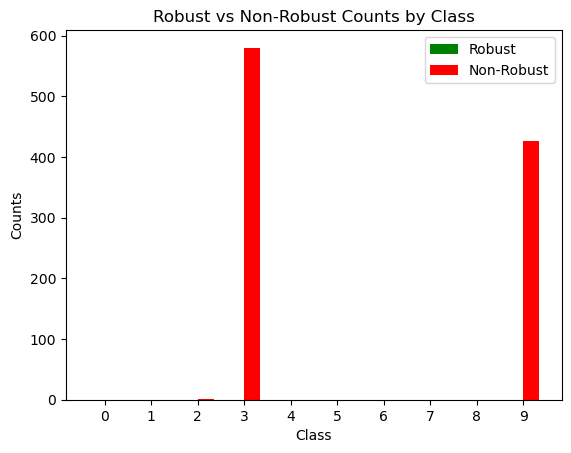

   Class  Robust  Non-Robust
0      0       0           0
1      1       0           0
2      2       0           1
3      3       0         580
4      4       0           0
5      5       0           0
6      6       0           0
7      7       0           0
8      8       0           0
9      9       0         426


In [199]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from wong_kolter import DualNetBounds
import pandas as pd

# Initialize your neural network model `net` here
# ...
epsilon=0.03
num_classes = 10
robust_counts = {i: 0 for i in range(num_classes)}
non_robust_counts = {i: 0 for i in range(num_classes)}

# Load dataset
mnist_test = datasets.MNIST('data', train=False, download=True, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=1, shuffle=False, pin_memory=True)

for i, (X, y) in enumerate(test_loader):
    if i >= 10000:  # Only check the first 10000 examples
        break
    logits = net(X)
    y_pred = logits.max(1)[1]
    if y_pred.item() == y.item():  # Check if the prediction is correct
        # Apply verification only for correct predictions
        dual_net = DualNetBounds(net, X, epsilon, bounded_input=True)
        C = torch.eye(num_classes).type_as(X)[y_pred].unsqueeze(1) - torch.eye(num_classes).type_as(X).unsqueeze(0)
        margins_lp_greedy = dual_net(C).data
        is_robust = np.all(margins_lp_greedy.flatten().numpy() >= 0)
        
        # Increment the robust count for the correct class
        if is_robust:
            robust_counts[y.item()] += 1
        else:
            non_robust_counts[y.item()] += 1

# Plotting the robust and non-robust counts for each class
classes = list(range(num_classes))
robust_values = [robust_counts[c] for c in classes]
non_robust_values = [non_robust_counts[c] for c in classes]

x = np.arange(len(classes))
bar_width = 0.35

fig, ax = plt.subplots()
bars1 = ax.bar(x - bar_width/2, robust_values, bar_width, label='Robust', color='green')
bars2 = ax.bar(x + bar_width/2, non_robust_values, bar_width, label='Non-Robust', color='red')

ax.set_xlabel('Class')
ax.set_ylabel('Counts')
ax.set_title('Robust vs Non-Robust Counts by Class')
ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.legend()

plt.show()

# Create a Pandas DataFrame for a table representation
df_counts = pd.DataFrame({
    'Class': class_labels,
    'Robust': robust_values,
    'Non-Robust': non_robust_values
})

print(df_counts)


## LP-LAST
This is the same as LP-GREEDY, but solves the exact primal LP on the last layer of the neural network, instead of solving the dual heuristically. The preactivation bounds on the internal neurons of the network are the ones used by LP-GREEDY. Therefore, LP-LAST is expected to be slightly tighter than LP-GREEDY.

#### Helper functions

In [6]:
def get_linearLayers_net(W, b):
    layers_list = [[nn.Linear(ww.shape[1],ww.shape[0]), nn.ReLU()] for ww in W]
    flat_layers_list = [item for sublist in layers_list for item in sublist]
    net = nn.Sequential(Flatten(),
                       *flat_layers_list[:-1]
                       )
    # Load weights
    i = 0
    for idx,l in enumerate(net):
        if isinstance(l, nn.Linear):
            l.weight.data = torch.Tensor(W[i])
            l.bias.data = torch.Tensor(b[i])
            i += 1
    return net


def init_affine(net, X):
    layers = [l for l in net if isinstance(l, (nn.Linear, nn.Conv2d))]
    affine = [Affine(l) for l in layers]

    _ = X.view(1,-1)
    for a in affine: 
        _ = a(_)

    biases = [full_bias(l, affine[i].out_features) 
                    for i,l in enumerate(layers)]
    return affine, biases

In [7]:
C = np.eye(num_classes)[y_pred] - np.eye(num_classes)

affine, biases = init_affine(net, X)
num_linear_layers = len(affine)

# Get the weights and biases from the network. Will be used in the LP formulation later. 
W = [l(Variable(torch.eye(l.in_features))).t().cpu().data.numpy() for l in affine]
b = [bias.view(-1).cpu().data.numpy() for bias in biases]

# Popoulate the preactivation bounds of all layers except the last layer.
zl = []
zu = []
for idx, (ww,bb) in enumerate(zip(W,b), start=1):
    dual_net = DualNetBounds(get_linearLayers_net(W[:idx], b[:idx]), X, epsilon, bounded_input=True)
    CC = torch.eye(ww.shape[0]).type_as(X).unsqueeze(0)
    zl.append(dual_net(CC).data.squeeze(0))
    CC = -torch.eye(ww.shape[0]).type_as(X).unsqueeze(0)
    zu.append(-dual_net(CC).data.squeeze(0))

# This LP formulation can be found in Appendix A.1 of Wong and Kolter 2018 (https://arxiv.org/abs/1711.00851).
# The implementation is modified from (https://github.com/locuslab/convex_adversarial)
z = [cp.Variable(l.in_features) for l in affine]
zhat = [cp.Variable(l.out_features) for l in affine]

# Constraints of the LP
cons_eq = [zhat[i] == W[i]*z[i] + b[i] for i in range(num_linear_layers)]
cons_ball = [z[0] >= sample - epsilon, z[0] <= sample + epsilon, z[0] >= 0, z[0] <= 1.0]
cons_zero = [z[i] >= 0 for i in range(1,num_linear_layers)]
cons_linear = [z[i+1] >= zhat[i] for i in range(num_linear_layers-1)]
cons_upper = [(cp.multiply(-(np.maximum(zu[i],0) - np.maximum(zl[i], 0)), zhat[i]) +
               cp.multiply((zu[i] - zl[i]), z[i+1]) <= 
               zu[i]*np.maximum(zl[i],0) - zl[i]*np.maximum(zu[i],0)) for i in range(num_linear_layers-1)]

cons = cons_eq + cons_ball + cons_zero + cons_linear + cons_upper

# For each neuron in the last layer, solve an LP to find the margin.
margins_lp_last = []
for node_idx in range(zu[-1].shape[0]):
    f_primal = cp.Problem(cp.Minimize(C[node_idx]*zhat[-1]), cons).solve(verbose=False, solver=cp.ECOS)
    margins_lp_last.append(f_primal)

/Users/aa3506phd/anaconda3/envs/lp-relaxation/lib/python3.12/site-packages/cvxpy/expressions/expression.py:621: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 1 times so far.

  warnings.warn(msg, UserWarning)
/Users/aa3506phd/anaconda3/envs/lp-relaxation/lib/python3.12/site-packages/cvxpy/expressions/expression.py:621: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2 times

Robustness certified for epsilon=0.01 using LP-LAST


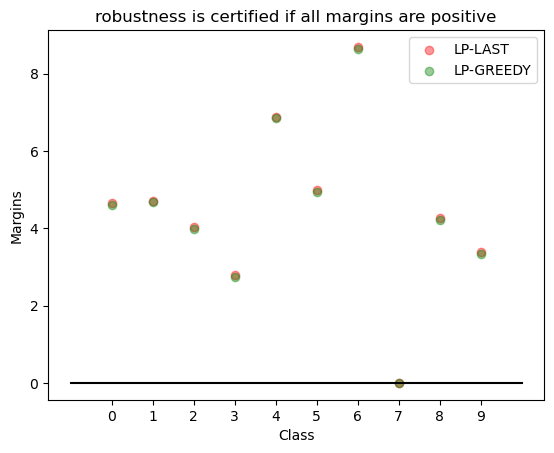

In [8]:
plt.scatter([i for i in range(10)],margins_lp_last, label='LP-LAST',color='r', alpha=0.4)
plt.scatter([i for i in range(10)], margins_lp_greedy, color='g', alpha=0.4, label='LP-GREEDY')
plt.plot([-1,10],[0,0], color='k')

plt.legend()
plt.title('robustness is certified if all margins are positive')
plt.ylabel('Margins')
plt.xlabel('Class')
plt.xticks([i for i in range(10)])
if np.all(np.array(margins_lp_last)>=0):
    print('Robustness certified for epsilon={} using LP-LAST'.format(epsilon))
else:
    print('Robustness NOT certified for epsilon={} using LP-LAST'.format(epsilon))

# LP-ALL
This is the layer-wise optimal convex relaxation formulation that is defined in Section 5.1 of [our paper](https://arxiv.org/abs/1902.08722). LP-ALL is tighter than both LP-LAST and LP-GREEDY.

In [9]:
C = np.eye(num_classes)[y_pred] - np.eye(num_classes)

affine, biases = init_affine(net, X)
num_linear_layers = len(affine)

# Get the weights and biases from the network. Will be used in the LP formulation later. 
W = [l(Variable(torch.eye(l.in_features))).t().cpu().data.numpy() for l in affine]
b = [bias.view(-1).cpu().data.numpy() for bias in biases]

zl = [[] for i in range(num_linear_layers)]
zu = [[] for i in range(num_linear_layers)]

for k in range(num_linear_layers):
    print('Layer: ',k)
    print('Number of nodes in layer {0} is {1}'.format(k, affine[k].out_features))
    z = [cp.Variable(l.in_features) for l in affine[:k+1]]
    zhat = [cp.Variable(l.out_features) for l in affine[:k+1]]

    # Constraints of the LP
    cons_eq = [zhat[i] == W[i]*z[i] + b[i] for i in range(k+1)]
    cons_ball = [z[0] >= sample - epsilon, z[0] <= sample + epsilon, z[0] >= 0, z[0] <= 1.0]
    cons_zero = [z[i] >= 0 for i in range(1,k+1)]
    cons_linear = [z[i+1] >= zhat[i] for i in range(k)]
    cons_upper = [(cp.multiply(-(np.maximum(zu[i],0) - np.maximum(zl[i], 0)), zhat[i]) +
                    cp.multiply((zu[i] - zl[i]), z[i+1]) <= 
                    zu[i]*np.maximum(zl[i],0) - zl[i]*np.maximum(zu[i],0)) for i in range(k)]
    cons = cons_eq + cons_ball + cons_zero + cons_linear + cons_upper

    margins_lp_all = []
    for node_idx in range(affine[k].out_features):
        if k == num_linear_layers-1:
            if node_idx == y_pred.item():
                margins_lp_all.append(0)
                continue
            f_primal_1 = cp.Problem(cp.Minimize(C[node_idx]*zhat[-1]), cons).solve(verbose=False, solver=cp.ECOS)
            margins_lp_all.append(f_primal_1)
        else:
            f_primal_1 = cp.Problem(cp.Minimize(zhat[-1][node_idx]), cons).solve(verbose=False, solver=cp.ECOS)
            f_min = zhat[-1][node_idx].value
            zl[k].append(f_min)

            f_primal_2 = cp.Problem(cp.Maximize(zhat[-1][node_idx]), cons).solve(verbose=False, solver=cp.ECOS)
            f_max = zhat[-1][node_idx].value
            zu[k].append(f_max)
    zl[k] = np.array(zl[k])
    zu[k] = np.array(zu[k])


Layer:  0
Number of nodes in layer 0 is 3136


/Users/aa3506phd/anaconda3/envs/lp-relaxation/lib/python3.12/site-packages/cvxpy/expressions/expression.py:621: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 15 times so far.

  warnings.warn(msg, UserWarning)


Layer:  1
Number of nodes in layer 1 is 1568


/Users/aa3506phd/anaconda3/envs/lp-relaxation/lib/python3.12/site-packages/cvxpy/expressions/expression.py:621: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 16 times so far.

  warnings.warn(msg, UserWarning)
/Users/aa3506phd/anaconda3/envs/lp-relaxation/lib/python3.12/site-packages/cvxpy/expressions/expression.py:621: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 17 tim

Layer:  2
Number of nodes in layer 2 is 100


/Users/aa3506phd/anaconda3/envs/lp-relaxation/lib/python3.12/site-packages/cvxpy/expressions/expression.py:621: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 18 times so far.

  warnings.warn(msg, UserWarning)
/Users/aa3506phd/anaconda3/envs/lp-relaxation/lib/python3.12/site-packages/cvxpy/expressions/expression.py:621: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 19 tim

Layer:  3
Number of nodes in layer 3 is 10


/Users/aa3506phd/anaconda3/envs/lp-relaxation/lib/python3.12/site-packages/cvxpy/expressions/expression.py:621: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 21 times so far.

  warnings.warn(msg, UserWarning)
/Users/aa3506phd/anaconda3/envs/lp-relaxation/lib/python3.12/site-packages/cvxpy/expressions/expression.py:621: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 22 tim

Robustness certified for epsilon=0.01 using LP-ALL


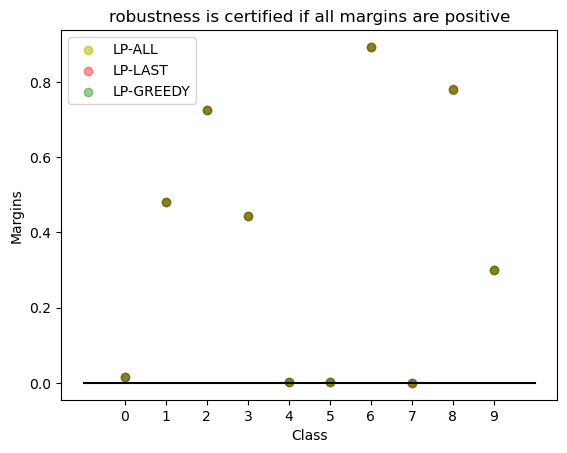

In [36]:
plt.scatter([i for i in range(10)], margins_lp_all, color='y', alpha=0.6, label='LP-ALL')
plt.scatter([i for i in range(10)], margins_lp_last, color='r', alpha=0.4, label='LP-LAST')
plt.scatter([i for i in range(10)], margins_lp_greedy, color='g', alpha=0.4, label='LP-GREEDY')
plt.plot([-1,10],[0,0], color='k')
plt.legend()
plt.title('robustness is certified if all margins are positive')
plt.ylabel('Margins')
plt.xlabel('Class')
plt.xticks([i for i in range(10)])
if np.all(np.array(margins_lp_all)>=0):
    print('Robustness certified for epsilon={} using LP-ALL'.format(epsilon))
else:
    print('Robustness NOT certified for epsilon={} using LP-ALL'.format(epsilon))

# MILP
This is a simple implementation of the MILP formulation for ReLU networks of the [Tjeng et. al., 2019](https://arxiv.org/abs/1711.07356). MILP solves the verification problem exactly, there fore is tighter than the above algorithms.

In [131]:
C = np.eye(num_classes)[y_pred] - np.eye(num_classes)

affine, biases = init_affine(net, X)
num_linear_layers = len(affine)

W = [l(Variable(torch.eye(l.in_features))).t().cpu().data.numpy() for l in affine]
b = [bias.view(-1).cpu().data.numpy() for bias in biases]

margins_milp = []
z = [cp.Variable(l.in_features) for l in affine[:num_linear_layers]]
zhat = [cp.Variable(l.out_features) for l in affine[:num_linear_layers]]
a = [cp.Variable(l.out_features, boolean=True) for l in affine[:num_linear_layers]]

# These MILP constraints can be found in the formulation presented 
# in Appendix A.1 of Tjeng et. al., 2019 (https://arxiv.org/abs/1711.07356)
cons_eq = [zhat[i] == W[i]*z[i] + b[i] for i in range(num_linear_layers)]
cons_ball = [z[0] >= sample - epsilon, z[0] <= sample + epsilon, z[0] >= 0, z[0] <= 1.0]
cons_zero = [z[i] >= 0 for i in range(1,num_linear_layers)]
cons_linear = [z[i+1] >= zhat[i] for i in range(num_linear_layers-1)]
cons_milp_1 = [z[i+1] <= cp.multiply(zu[i],a[i]) for i in range(num_linear_layers-1)]
cons_milp_2 = [z[i+1] <= zhat[i] - cp.multiply(zl[i],(1 - a[i])) for i in range(num_linear_layers-1)]

cons = cons_eq + cons_ball + cons_zero + cons_linear + cons_milp_1 + cons_milp_2

for node_idx in range(affine[num_linear_layers-1].out_features):
    if node_idx == y_pred.item():
        margins_milp.append(0)
        continue
    f_primal_1 = cp.Problem(cp.Minimize(C[node_idx]*zhat[-1]), cons).solve(verbose=False, solver=cp.ECOS_BB)
    margins_milp.append(f_primal_1)

/Users/aa3506phd/anaconda3/envs/lp-relaxation/lib/python3.12/site-packages/cvxpy/expressions/expression.py:621: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 81 times so far.

  warnings.warn(msg, UserWarning)
/Users/aa3506phd/anaconda3/envs/lp-relaxation/lib/python3.12/site-packages/cvxpy/expressions/expression.py:621: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 82 tim

Robustness certified for epsilon=0.04 using MILP


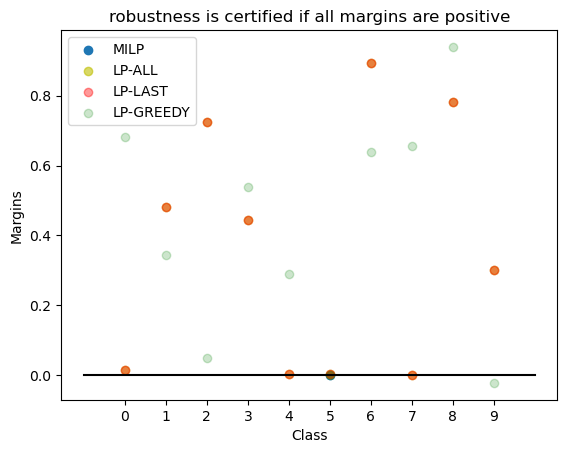

In [132]:
plt.scatter([i for i in range(10)], margins_milp, label='MILP')
plt.scatter([i for i in range(10)], margins_lp_all, color='y', alpha=0.6, label='LP-ALL')
plt.scatter([i for i in range(10)], margins_lp_last, color='r', alpha=0.4, label='LP-LAST')
plt.scatter([i for i in range(10)], margins_lp_greedy, color='g', alpha=0.2, label='LP-GREEDY')
plt.plot([-1,10],[0,0], color='k')
plt.legend()
plt.title('robustness is certified if all margins are positive')
plt.ylabel('Margins')
plt.xlabel('Class')
plt.xticks([i for i in range(10)])
if np.all(np.array(margins_milp)>=0):
    print('Robustness certified for epsilon={} using MILP'.format(epsilon))
else:
    print('Robustness NOT certified for epsilon={} using MILP'.format(epsilon))